In [21]:
# import shutil

# shutil.rmtree('/content/raw_fish_dataset')
# shutil.rmtree('/content/train')
# shutil.rmtree('/content/val')

In [22]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# extract files
!unzip -o /content/drive/MyDrive/raw_fish_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw_fish_dataset/Red Sea Bream/00005.png  
  inflating: raw_fish_dataset/Red Sea Bream/00006.png  
  inflating: raw_fish_dataset/Red Sea Bream/00007.png  
  inflating: raw_fish_dataset/Red Sea Bream/00008.png  
  inflating: raw_fish_dataset/Red Sea Bream/00009.png  
  inflating: raw_fish_dataset/Red Sea Bream/00010.png  
  inflating: raw_fish_dataset/Red Sea Bream/00011.png  
  inflating: raw_fish_dataset/Red Sea Bream/00012.png  
  inflating: raw_fish_dataset/Red Sea Bream/00013.png  
  inflating: raw_fish_dataset/Red Sea Bream/00014.png  
  inflating: raw_fish_dataset/Red Sea Bream/00015.png  
  inflating: raw_fish_dataset/Red Sea Bream/00016.png  
  inflating: raw_fish_dataset/Red Sea Bream/00017.png  
  inflating: raw_fish_dataset/Red Sea Bream/00018.png  
  inflating: raw_fish_dataset/Red Sea Bream/00019.png  
  inflating: raw_fish_dataset/Red Sea Bream/00020.png  
  inflating: raw_fish_dataset/Red Sea Bream/00021.png

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Define the paths
base_dir = '/content/raw_fish_dataset'
train_dir = '/content/train'
val_dir = '/content/val'

# Create train and val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get class names from the base directory
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Split data into training and validation sets
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)

    train_images, val_images = train_test_split(images, test_size=0.3, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))

    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(val_dir, class_name, img))

In [26]:
# Image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical'
)

Found 6300 images belonging to 9 classes.
Found 2700 images belonging to 9 classes.


In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
315/315 [==============================] - 129s 402ms/step - loss: 1.8239 - accuracy: 0.2883 - val_loss: 1.1463 - val_accuracy: 0.5563
Epoch 2/30
315/315 [==============================] - 121s 384ms/step - loss: 1.0654 - accuracy: 0.5924 - val_loss: 0.7160 - val_accuracy: 0.7307
Epoch 3/30
315/315 [==============================] - 116s 367ms/step - loss: 0.8032 - accuracy: 0.6933 - val_loss: 0.6153 - val_accuracy: 0.7659
Epoch 4/30
315/315 [==============================] - 134s 426ms/step - loss: 0.6172 - accuracy: 0.7624 - val_loss: 0.6297 - val_accuracy: 0.7696
Epoch 5/30
315/315 [==============================] - 115s 366ms/step - loss: 0.5108 - accuracy: 0.8095 - val_loss: 0.4525 - val_accuracy: 0.8407
Epoch 6/30
315/315 [==============================] - 117s 371ms/step - loss: 0.4335 - accuracy: 0.8392 - val_loss: 0.4802 - val_accuracy: 0.8104
Epoch 7/30
315/315 [==============================] - 116s 367ms/step - loss: 0.3632 - accuracy: 0.8646 - val_loss: 0.1170 -

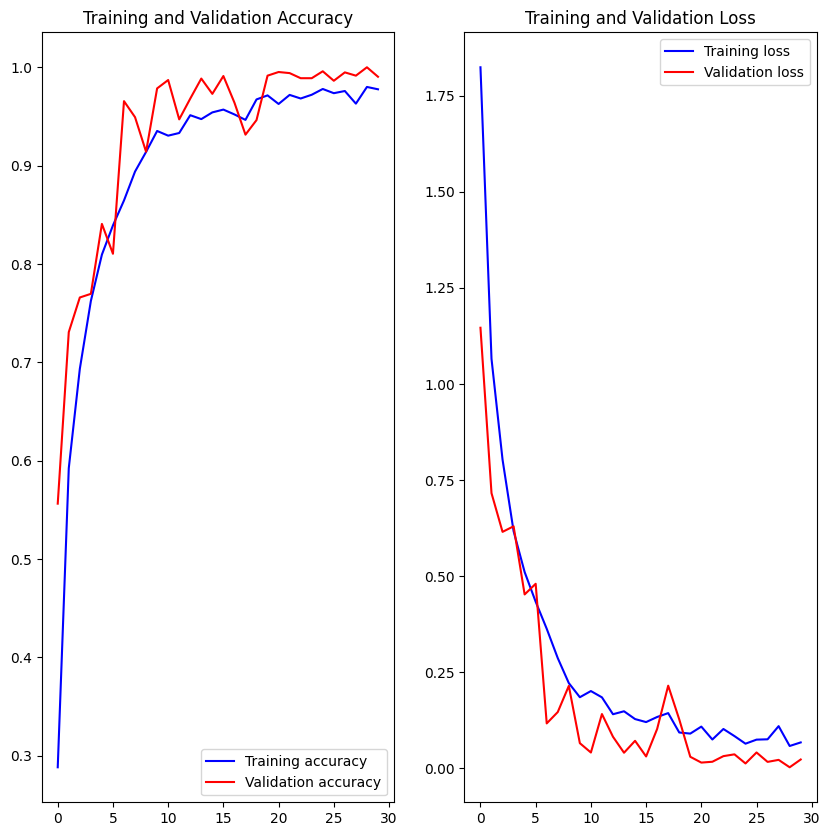

In [29]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [30]:
model.save('fish_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
# Assuming you have already trained your model and it is named `model`
model.save('/content/drive/MyDrive/fish_classifier_model.h5')

In [31]:
# import tensorflow as tf

# # Konversi model ke TensorFlow Lite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Simpan model TensorFlow Lite ke file
# with open('fish_classifier_model.tflite', 'wb') as f:
#     f.write(tflite_model)

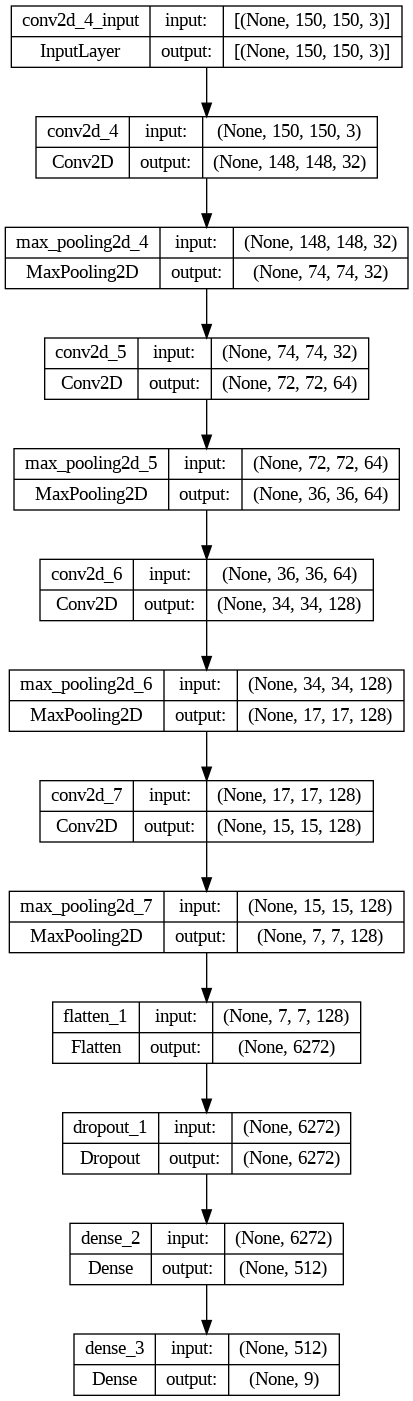

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

1/1 [==============================] - 0s 437ms/step


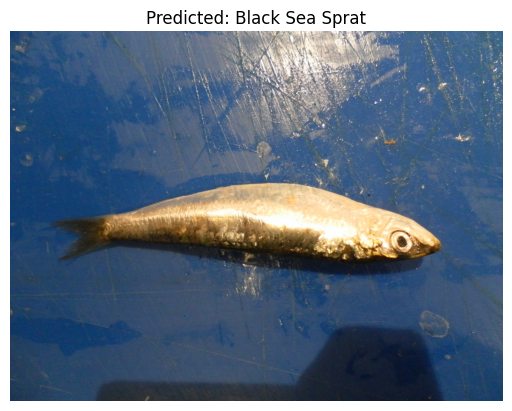

Image: 00017.png
Prediction Probabilities: [[9.9997628e-01 4.2306753e-10 3.1568680e-07 9.7881048e-10 2.8560897e-14
  2.2125085e-05 2.9793550e-14 1.2284618e-06 1.2815215e-11]]
1/1 [==============================] - 0s 18ms/step


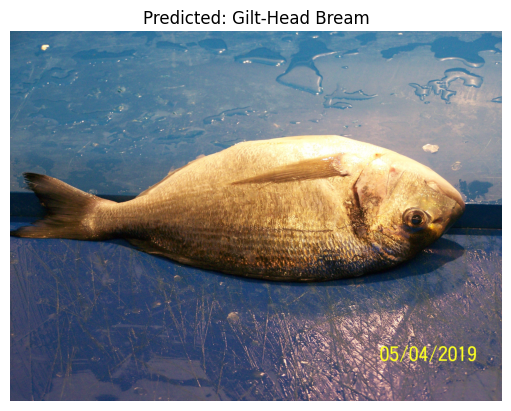

Image: 17.JPG
Prediction Probabilities: [[1.0602317e-12 9.9981588e-01 2.1083797e-10 7.3231161e-12 8.2650864e-08
  1.8391074e-04 4.8111179e-15 1.8427871e-08 8.4196493e-08]]
1/1 [==============================] - 0s 34ms/step


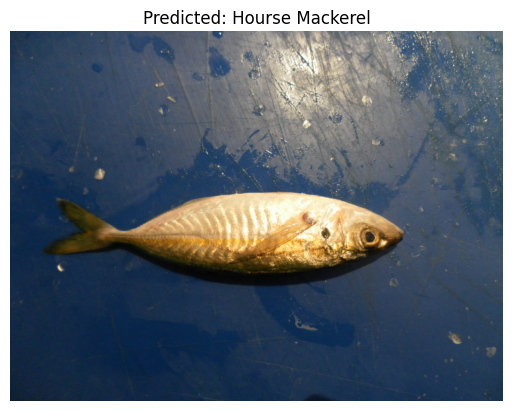

Image: 00025.png
Prediction Probabilities: [[9.6107833e-03 5.0720329e-05 9.8677140e-01 8.1265206e-08 3.1401044e-09
  4.9145235e-04 4.0546431e-11 3.0753857e-03 1.0576564e-07]]
1/1 [==============================] - 0s 29ms/step


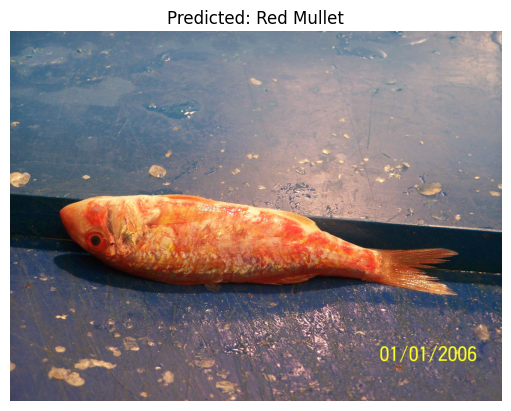

Image: 00014.png
Prediction Probabilities: [[6.6701800e-17 1.4157512e-22 1.6253624e-27 1.0000000e+00 4.0972300e-33
  1.4855795e-16 3.1657439e-18 5.0539772e-09 6.6582625e-23]]
1/1 [==============================] - 0s 17ms/step


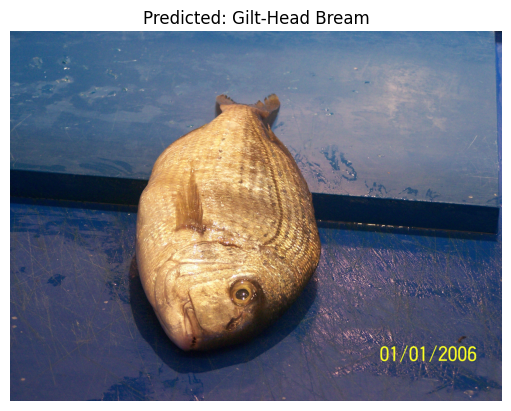

Image: 100_1465.JPG
Prediction Probabilities: [[1.2975285e-16 9.3465000e-01 8.7899910e-09 9.2574668e-13 6.4094447e-02
  2.7292484e-04 8.1498927e-16 1.1829579e-08 9.8257896e-04]]
1/1 [==============================] - 0s 17ms/step


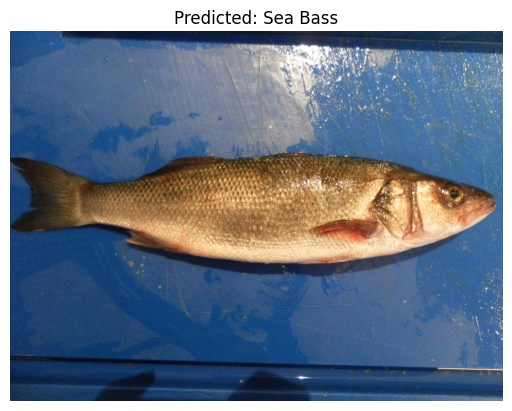

Image: 44.JPG
Prediction Probabilities: [[6.3358853e-11 4.5921770e-05 2.7986624e-09 1.0493910e-15 5.1418548e-13
  9.9995410e-01 8.1218792e-24 2.4694678e-12 8.6555803e-09]]
1/1 [==============================] - 0s 17ms/step


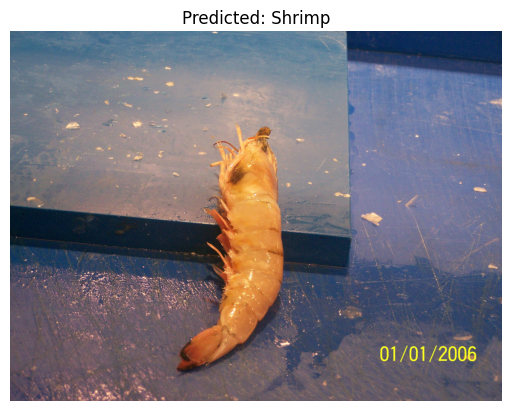

Image: 00024.png
Prediction Probabilities: [[8.5805515e-14 1.2684625e-12 7.3270014e-13 4.1942531e-06 3.5068448e-11
  1.2671226e-05 9.9998057e-01 2.6348009e-06 4.0478976e-21]]
1/1 [==============================] - 0s 19ms/step


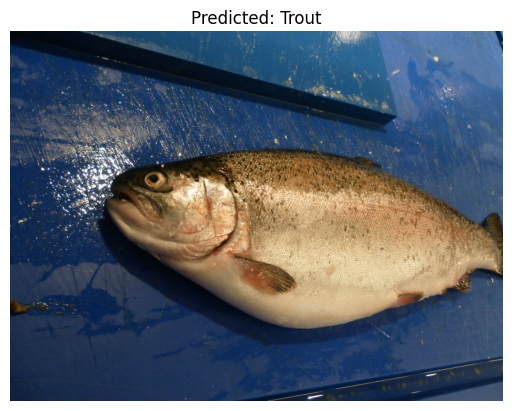

Image: 00012.png
Prediction Probabilities: [[1.06608034e-26 9.24187261e-05 2.67393292e-14 3.63355240e-20
  2.59879926e-07 2.77624139e-11 7.09161598e-25 4.35276600e-17
  9.99907255e-01]]
1/1 [==============================] - 0s 18ms/step


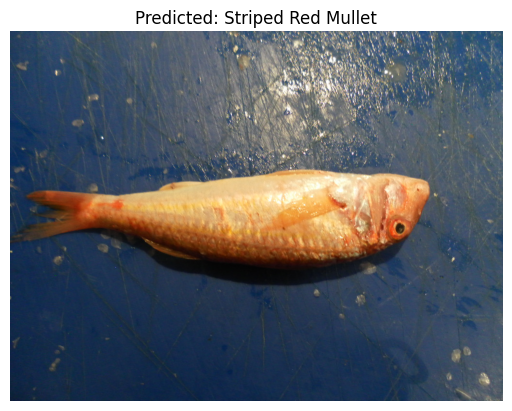

Image: 00040.png
Prediction Probabilities: [[1.3060146e-09 1.0407870e-09 2.0917465e-14 3.1836218e-01 3.2963558e-15
  1.0758943e-08 3.7899936e-05 6.8159997e-01 2.7183231e-15]]


In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Load your trained model
model = tf.keras.models.load_model('/content/fish_classifier_model.h5')

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Function to make a prediction
def predict_image(img_path, model, class_labels):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_class]
    return predicted_label, predictions

# Path to the test folder containing random images
test_folder_path = '/content/drive/MyDrive/test'

# Get class labels from the test generator or define them manually
class_labels = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

# Loop through each image in the test folder
for img_file in os.listdir(test_folder_path):
    img_path = os.path.join(test_folder_path, img_file)
    if os.path.isfile(img_path):  # Ensure it's a file
        predicted_label, predictions = predict_image(img_path, model, class_labels)

        # Display the image with the predicted label
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()

        # Print the prediction probabilities
        print(f"Image: {img_file}")
        print("Prediction Probabilities:", predictions)

# Optionally, you could save the results to a file or log for later analysis

1/1 [==============================] - 0s 79ms/step


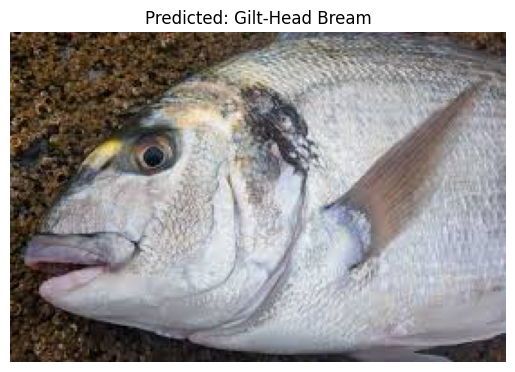

Prediction Probabilities: [[3.01427872e-06 8.79032612e-01 1.30663984e-05 2.93536203e-07
  4.04408061e-12 1.20599970e-01 4.06530148e-12 1.13618256e-07
  3.50965711e-04]]


In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/content/fish_classifier_model.h5')

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Function to make a prediction
def predict_image(img_path, model, class_labels):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_class]
    return predicted_label, predictions

# Path to the random image
img_path = '/content/ghb.jpeg'

# Get class labels from the test generator or you can define them manually
class_labels = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

# Make a prediction
predicted_label, predictions = predict_image(img_path, model, class_labels)

# Display the image with the predicted label
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()

# Print the prediction probabilities
print("Prediction Probabilities:", predictions)
